# Fine-tuning on Pre-trained Model with Batch Integration
In this tutorial, we demonstrate how to fine-tune a pre-trained model on a new dataset for the batch integration task. We use the PBMC 10K dataset as an example and fine-tune on the pre-trained whole-body model. 

We summarize the fine-tuning pipeline in the following steps, which can be used as a general recipe for finetuning on integration tasks and beyond: 

     1. Specify hyper-parameter setup for integration task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. Finetune scGPT with task-specific objectives
     
     5. Evaluate fine-tuned scGPT


In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
sys.path.insert(0, "../")
from scgpt.tokenizer.gene_tokenizer import GeneVocab
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directl

## Step1: Specify hyper-parameter setup for integration task
Here we provide some hyper-parameter recommendations here for the integration task. Note that the PBMC 10K dataset contains multiple batches to be integrated. Therefore, in addition to the default gene modelling objectives, we also turn on ESC, DAR and DSBN objectives specifically to faciliate batch integration.

In [2]:
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="Covid_19", # Dataset name
    do_train=False, # Flag to indicate whether to do update model parameters during training
    load_model="../save/scGPT_human", # Path to pre-trained model
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0, # DAR objective weight for batch correction
    mask_ratio=0.4, # Default mask ratio
    epochs=15, # Default number of epochs for fine-tuning
    n_bins=51, # Default number of bins for value binning in data pre-processing
    lr=1e-4, # Default learning rate for fine-tuning
    batch_size=64, # Default batch size for fine-tuning
    layer_size=128,
    nlayers=4,
    nhead=4, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
)
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xjk0911 (jiankaixiao). Use `wandb login --relogin` to force relogin


{'seed': 42, 'dataset_name': 'Covid_19', 'do_train': False, 'load_model': '../save/scGPT_human', 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'mask_ratio': 0.4, 'epochs': 15, 'n_bins': 51, 'lr': 0.0001, 'batch_size': 64, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [3]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 1200  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

In [4]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_Covid_19-Oct22-16-52


adata = sc.read_h5ad('/mnt/disk1/xiaojk/code/scGPT/scGPT/tutorials/data/covid_subsampled.h5ad')  # 20000 × 1200## Step 2: Load and pre-process data

adata### 2.1 Load the PBMC 10K data

In [5]:
if dataset_name == "Covid_19":
    adata = sc.read_h5ad('/mnt/disk1/xzhou/data/bigmodel/scGPT/panc8.h5ad')  # 20000 × 1200
    ori_batch_col = "tech"
    adata.obs["celltype"] = adata.obs["celltype"].astype("category")
    adata.var = adata.var.set_index("features")
    data_is_raw = True

# make the batch category column
adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

### 2.2 Cross-check gene set with the pre-trained model 
Note that we retain the common gene set between the data and the pre-trained model for further fine-tuning.

In [6]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]
    
    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size 
    nhead = config.nhead
    nlayers = config.nlayers  
    d_hid = config.layer_size

scGPT - INFO - match 25278/34363 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ../save/scGPT_human/best_model.pt, the model args will be overriden by the config ../save/scGPT_human/args.json.


### 2.3 Pre-process the data
We follow the standardized pipline of depth normalization, log normalization, and highly vairable gene (HVG) selection for data pre-processing. We further introduced value binning to obtain the relative expressions of each HVG.

In [7]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg= False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
adata = preprocessor(adata, batch_key="str_batch" if dataset_name != "heart_cell" else None)


scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


In [8]:
if per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

### 2.4 Tokenize the input data for model fine-tuning

In [9]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)


In [10]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

In [11]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)



scGPT - INFO - train set number of samples: 13401, 
	 feature length: 1201
scGPT - INFO - valid set number of samples: 1489, 
	 feature length: 1201


In [12]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

 ## Step 3: Load the pre-trained scGPT model

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
#     fast_transformer_backend="linear",
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)
wandb.watch(model)

Use domain specific batchnorm with affine=False
scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading params transformer_encoder.layers.

[]

In [14]:
criterion = masked_mse_loss
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [15]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc = 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if DSBN else None,
                MVC=config.GEPC,
                ECS=config.ecs_thres > 0,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = loss_mse = criterion(
                output_dict["mlm_output"], target_values, masked_positions
            )
            metrics_to_log = {"train/mse": loss_mse.item()}
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc
                metrics_to_log.update({"train/mvc": loss_gepc.item()})
            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob
                metrics_to_log.update(
                    {"train/mvc_nzlp": loss_gepc_zero_log_prob.item()}
                )
            if config.ecs_thres > 0:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
            loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
            loss = loss + config.dab_weight * loss_dab
            metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        wandb.log(metrics_to_log)

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item()
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            start_time = time.time()


def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if DSBN else None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/mre": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + config.dab_weight * total_dab)
            / total_num,
            "epoch": epoch,
        },
    )

    return total_loss / total_num, total_error / total_num


def eval_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            logger.error(e)

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_bio = {results.get('avg_bio', 0.0):.4f}"],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["batch_umap"] = fig

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[
                f"celltype, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["celltype_umap"] = fig

    if len(include_types) == 1:
        return results

## Step 4: Finetune scGPT with task-specific objectives

random masking at epoch   1, ratio of masked values in train:  0.3997
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time:  4.17s | valid loss/mse 113.6889 | mre 4537417.3912
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 113.6889
random masking at epoch   2, ratio of masked values in train:  0.3997
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   2 | time:  3.46s | valid loss/mse 113.5254 | mre 4540259.0695
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 113.5254
random masking at epoch   3, ratio of masked values in train:  0.3997
scGPT - INFO - ---------------------------------------------------------------------------

100%|██████████| 233/233 [00:36<00:00,  6.45it/s]


NMI...
ARI...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...


/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https:

scGPT - INFO -                                   0
NMI_cluster/label          0.037250
ARI_cluster/label          0.013546
ASW_label                  0.454018
ASW_label/batch            0.861126
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.517501
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.4540, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): 0.8611, graph connectivity: 0.5175, graph iLISI: nan
random masking at epoch   6, ratio of masked values in train:  0.3997
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch

100%|██████████| 233/233 [00:36<00:00,  6.34it/s]
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...


/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https:

scGPT - INFO -                                   0
NMI_cluster/label          0.043261
ARI_cluster/label          0.013763
ASW_label                  0.453743
ASW_label/batch            0.856866
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.522444
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.4537, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): 0.8569, graph connectivity: 0.5224, graph iLISI: nan


/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https:

random masking at epoch  11, ratio of masked values in train:  0.3997
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  11 | time:  3.59s | valid loss/mse 113.9161 | mre 4539074.5722
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  12, ratio of masked values in train:  0.3997
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  12 | time:  3.52s | valid loss/mse 113.5923 | mre 4540535.6521
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  13, ratio of masked values in train:  0.3997
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  13 | time:  3.52s | valid loss/mse 113.9960 | 

100%|██████████| 233/233 [00:36<00:00,  6.43it/s]
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...


/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https:

scGPT - INFO -                                   0
NMI_cluster/label          0.043261
ARI_cluster/label          0.013763
ASW_label                  0.453743
ASW_label/batch            0.856866
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.522444
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.4537, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): 0.8569, graph connectivity: 0.5224, graph iLISI: nan


/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https:

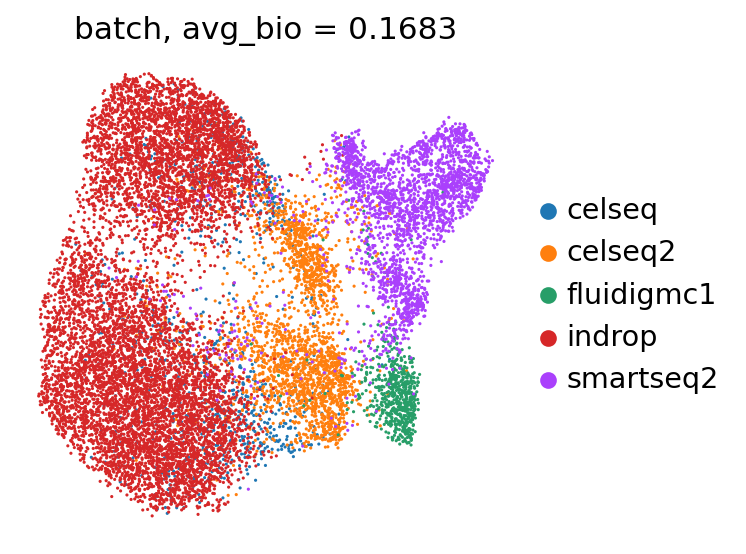

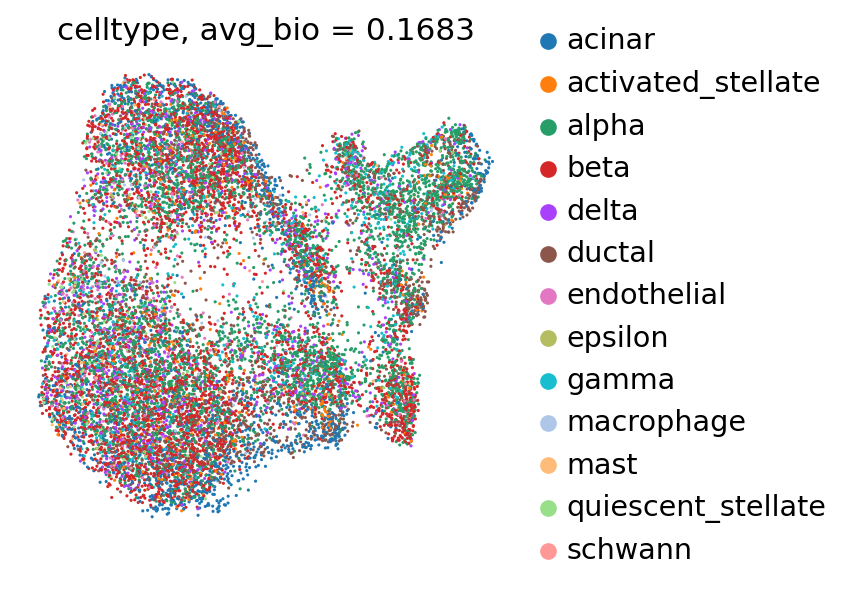

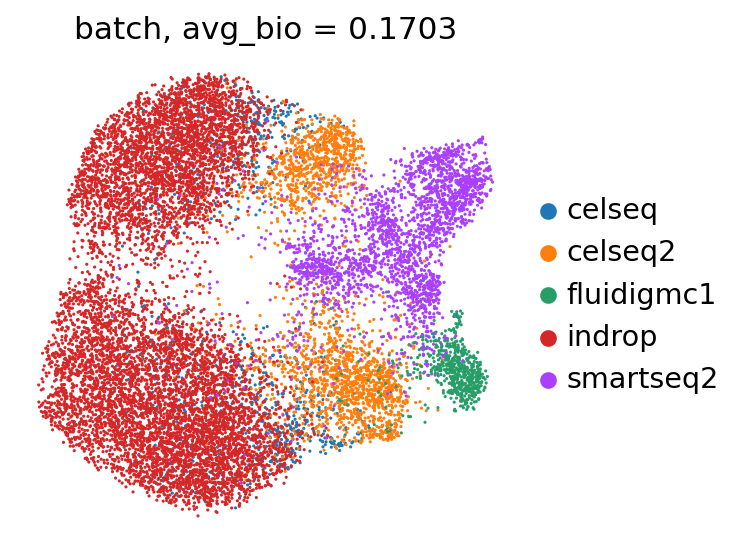

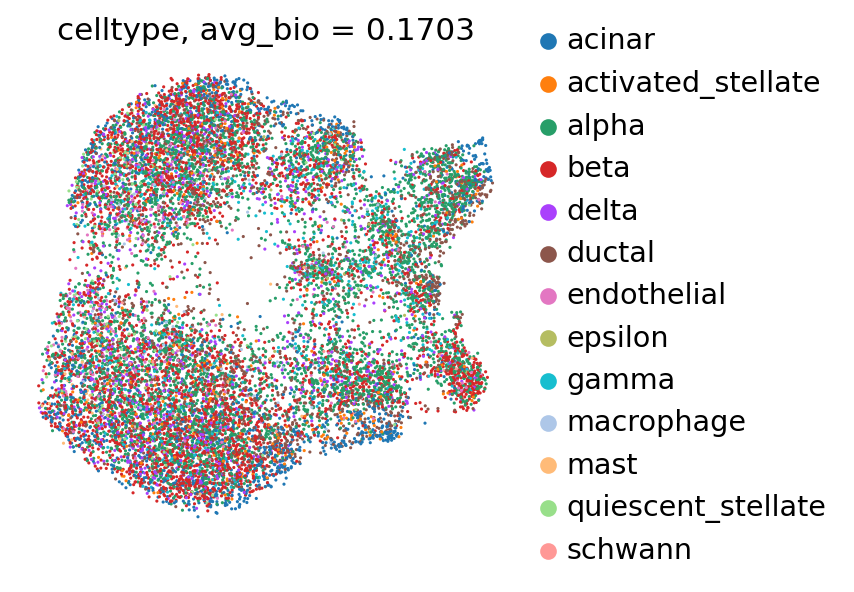

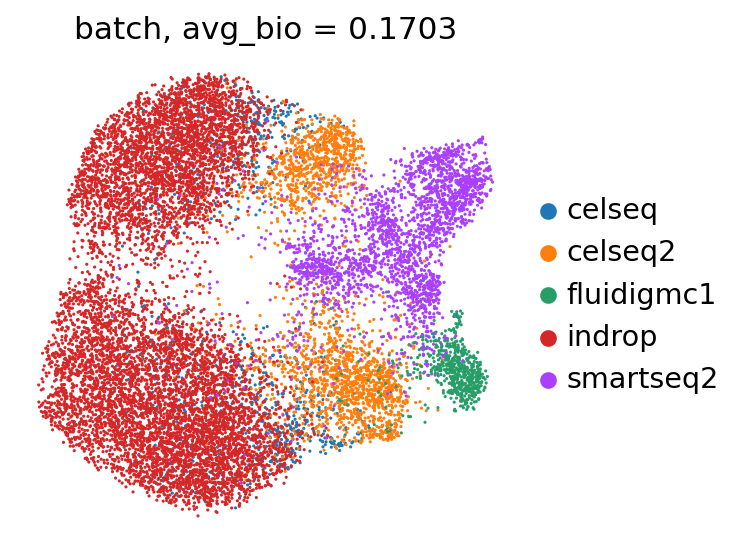

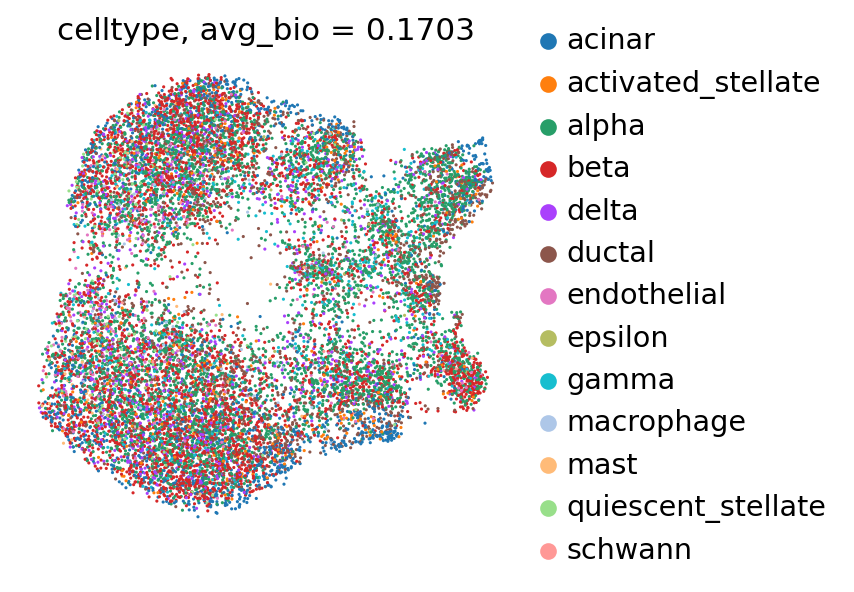

In [16]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_mre = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | mre {val_mre:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            best_model,
            adata_t=adata_sorted if per_seq_batch_sample else adata,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )

        metrics_to_log["test/celltype_umap"] = wandb.Image(
            str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()

In [17]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

In [18]:
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()

/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:73: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


avg_bio,▁██
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test/ARI_cluster/label,▁██
test/ASW_label,█▁▁
test/ASW_label/batch,█▁▁
test/NMI_cluster/label,▁██
test/PCR_batch,▁▁▁
test/avg_bio,▁██
test/best_model_epoch,▁▁▁
test/graph_conn,▁██
valid/dab,▃▂▇▇▃▂▂█▃▁▂▂█▃▁


134164

In [19]:
# import torch


# # 将模型切换到推断模式，以确保不进行梯度更新
# model.eval()

# # 使用torch.no_grad()上下文管理器，确保在模型前向传播期间不进行梯度计算
# with torch.no_grad():
#     # 将数据传递给模型进行推断
#     output = model(adata)

# # 现在output包含了模型的预测结果，而模型的权重没有更新


In [20]:
best_model

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(5, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dsbn): DomainSpecificBatchNorm1d(
    (bns): ModuleList(
      (0-4): 5 x BatchNorm1d(512, eps=6.1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=5

scGPT - INFO - Evaluating cls cell embeddings


100%|██████████| 134/134 [00:20<00:00,  6.53it/s]
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.046879
ARI_cluster/label          0.016636
ASW_label                  0.474886
ASW_label/batch                 NaN
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.506378
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.4749, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): nan, graph connectivity: 0.5064, graph iLISI: nan


/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/mnt/disk1/xiaojk/anaconda/envs/scGPT1/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https:

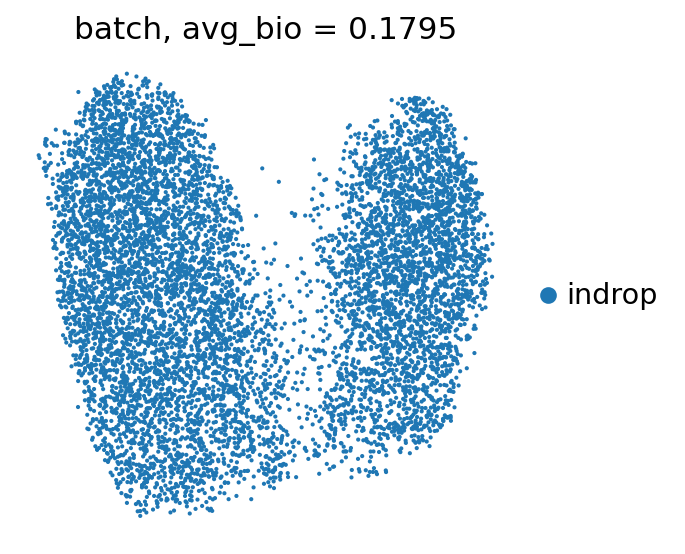

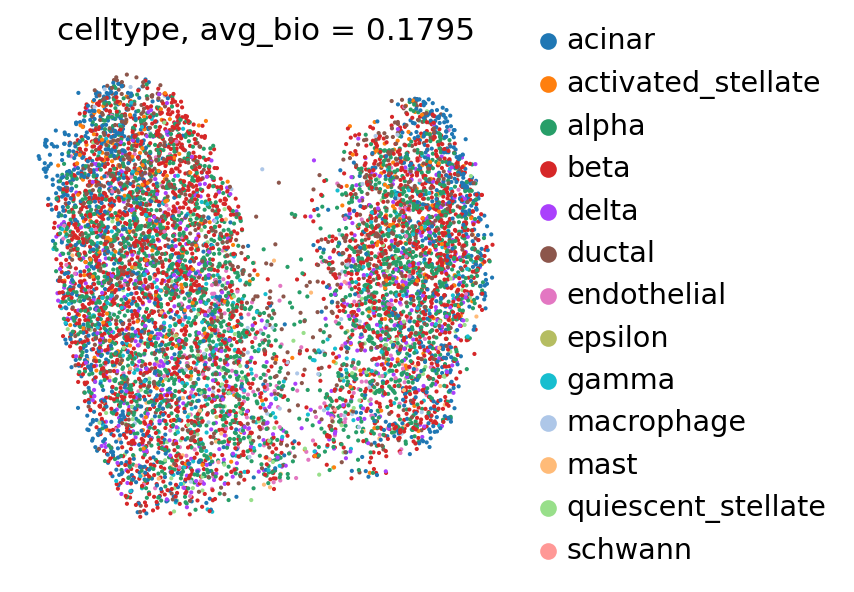

In [22]:
results = eval_testdata(
            best_model,
            adata_t = adata[adata.obs['tech']=='indrop',:],
            include_types=["cls"],
        )